### Analyses of output files from the pipeline optimus v6.0.0+
#### Aim of this part of analysis is to filter out the low quality cells

#### Load necessary libraries and useful functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Union
import fsspec
import anndata
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
from cellbender.remove_background.downstream import anndata_from_h5
from scipy.stats import median_abs_deviation
import dalmatian as dm
import collections

In [3]:
import warnings
warnings.filterwarnings("ignore") 

In [4]:
def read_file_from_url(url: str) -> Union[anndata.AnnData, pd.DataFrame]:
    """Read a file from a URL and return the appropriate data structure.

    Parameters
    ----------
    url : str
        The URL of the file to read.

    Returns
    -------
    output : Union[anndata.AnnData, pd.DataFrame]
        The data read from the file, which can be either an AnnData object (if ".h5ad" in url)
        or a Pandas DataFrame (if ".csv" in url).
    """

    with fsspec.open(url) as f:
        if ".h5ad" in url:
            output = anndata.read_h5ad(f)
        elif "Summary.csv" in url:
            output = pd.read_csv(f, header=None) #Read the CSV file with the first row as data
        elif ".csv" in url:
            output = pd.read_csv(f)
        else:
            raise ValueError("Unsupported file format. Supported formats are .h5ad and .csv.")
    
    return output

In [5]:
def human_mt_genes_ident(in_adata: anndata.AnnData) -> None:
    """Identify human mitochondrial genes, add the boolean column "mt" to adata.var 
    This function also check if the adata contains mouse mt genes
    NB mitochondrial genes MT- for human data and mt- for mouse data
    
    Parameters
    ----------
    in_adata : AnnData
        The AnnData object to check.
    
    Returns
    -------
    output : None
    """
    
    count_true = (in_adata.var_names.str.startswith("mt-")).sum()
    
    if count_true > 0:
        print("Mouse mt number", count_true)
    else:
        print("No mouse mt genes")
        print("Adding human mt genes to adat.var")
        in_adata.var["mt"] = in_adata.var_names.str.startswith("MT-")

In [6]:
def qc_plots(in_adata: anndata.AnnData, data_source: str, batch: str) -> None:
    """Plot QC plots for the given AnnData object.
    
    Parameters
    ----------
    in_adata : AnnData
        The AnnData object to check.
    
    data_source : str
        The data source of the AnnData object.

    batch : str
        The name of the column that contains batch information.
        If batch is None, p5 will not be plotted.
    
    Returns
    -------
    output : None
    """
    
    p1 = sns.displot(
        in_adata.obs["total_counts"],
        bins=100,
        kde=False
    )
    p1.set(
        xlabel="Distribution of counts per barcodes",
        ylabel="Counts per barcode"
    )
    p1.fig.savefig(f"displot_{data_source}_total_counts.pdf")

    p2 = sc.pl.violin(
        in_adata,
        keys = 'total_counts',
        jitter=False,
        save=f"_{data_source}_total_counts.pdf"
    )

    p3 = sc.pl.violin(
        in_adata,
        keys = "pct_counts_mt",
        #show=False,
        jitter=False,
        save = f"_{data_source}_pct_mt.pdf"
    ) # jitter=False to remove the dots

    p4 = sc.pl.scatter(
        in_adata,
        x="total_counts",
        y="n_genes_by_counts",
        color="pct_counts_mt",
        #show=False,
        title="#reads x #genes colored by percentage of mitochondiral genes",
        save=f"_{data_source}_counts_n_genes_by_counts.pdf"
    )
    """
    p4.set(
        title="#reads x #genes colored by percentage of mitochondiral genes",
        xlabel="Number of reads per barcode",
        ylabel="Number of expressed genes per barcode",
    )
    """

    ## %mt by batch in violin plots
    if batch is not None:
        violin_params = {
            'adata': in_adata,
            'keys': "pct_counts_mt",
            #'show': False,
            'jitter': False,
            'rotation': 90,
            'title': "Proportion of mitochondrial reads per barcode in function of {batch}",
            'save': f"_{data_source}_pct_mt_by_{batch}.pdf",
        }

        if batch == "emptydrops_IsCell":
            # Create a mapping dictionary
            mapping = {True: "True", False: "False"}
            # Apply the mapping to the emptydrops_IsCell column
            in_adata.obs["emptydrops_IsCell_category"] = in_adata.obs["emptydrops_IsCell"].map(mapping)
            
            # Update parameters for this case
            violin_params.update({
                'groupby': "emptydrops_IsCell_category"
            })
        else:
            # Update parameters for this case
            violin_params.update({
                'groupby': batch
            })

        # Plot the violin plot
        p5 = sc.pl.violin(**violin_params)

        """
        p5.set(title="Proportion of mitochondrial reads per barcode per sample in function of emptyDrops cell calling result")
        """
    
    return

In [7]:
def is_outlier(adata, metric: str, nmads: int) -> bool:
    """Function that takes a metric, i.e. a column in .obs and the number of MADs (nmad).
    This function is from https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html#filtering-low-quality-reads/,
    which is a part of the best practices for single cell RNA-seq analysis. Please cite the authors if you use this function.
    
    Parameters
    ----------
    adata : AnnData
        The AnnData object to check.
    
    metric : str
        The name of the column that contains the metric to check.
    
    nmads : int
        The number of MADs to use to define outliers.
    
    Returns
    -------
    output : bool
        True if the metric is an outlier, False otherwise.
    """
    
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

#### Data Loading

In this analysis, we load the data from the output file of job (submission ID 94e3d5584-ac31-456a-b046-4c8554108b7d)

In [8]:
TERRA_WS = "whitelabgx/scRNAseq"
wm = dm.WorkspaceManager(TERRA_WS)
output_df = wm.get_sample_sets()
display(output_df)
display(output_df.columns)

,cell_metrics,cellbender_html_report_array,samples,matrix,cellbender_metrics_csv_array,gene_metrics,genomic_reference_version,cellbender_cell_barcodes_csv,aligner_metrics,matrix_row_index,bam,matrix_col_index,h5ad_output_file,cell_calls,cellbender_h5_array,cellbender_summary_pdf
sample_set_id,,,,,,,,,,,,,,,,
optimus_workflow_2023-10-27,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,[gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/...,"[pbmc_10k_v3_S1_L001, pbmc_10k_v3_S1_L002]",gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,[gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,[gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...
optimus_workflow_2023-11-08,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,[gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/...,"[pbmc_10k_v3_S1_L001, pbmc_10k_v3_S1_L002]",gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,[gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,NaN,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...,[gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/...,gs://fc-447aee29-8362-4c0b-b8d0-b3b10eb9e2a6/s...


Index(['cell_metrics', 'cellbender_html_report_array', 'samples', 'matrix',
       'cellbender_metrics_csv_array', 'gene_metrics',
       'genomic_reference_version', 'cellbender_cell_barcodes_csv',
       'aligner_metrics', 'matrix_row_index', 'bam', 'matrix_col_index',
       'h5ad_output_file', 'cell_calls', 'cellbender_h5_array',
       'cellbender_summary_pdf'],
      dtype='object')

h5ad file of optimus

###### You can load the h5ad directly form the bucket, or you can download it from the bucket and load it locally.

In [ ]:
### Load h5ad file from terra platform
"""
h5ad_url = output_df.loc[output_df.index[0], 'h5ad_output_file']
#h5ad_url = output_df.loc['optimus_workflow_2023-10-27', 'h5ad_output_file']
adata = read_file_from_url(h5ad_url)
"""

In [9]:
### Load the data locally, more quickly
input_h5ad_raw = "../scAtlas/tmp/10k_pbmc_v3.h5ad"
input_h5ad_cellbender = "../scAtlas/tmp/10k_pbmc_v3_out_filtered_cellbenderDefault.h5"

adata = sc.read_h5ad(input_h5ad_raw)
adata_cellbender = anndata_from_h5(input_h5ad_cellbender)

Assuming we are loading a "filtered" file that contains only cells.


In [10]:
display(adata)
display(adata_cellbender)

AnnData object with n_obs × n_vars = 1136912 × 58347
    obs: 'cell_names', 'CellID', 'emptydrops_Limited', 'emptydrops_IsCell', 'n_reads', 'noise_reads', 'perfect_molecule_barcodes', 'reads_mapped_exonic', 'reads_mapped_exonic_as', 'reads_mapped_intronic', 'reads_mapped_intronic_as', 'reads_mapped_uniquely', 'reads_mapped_multiple', 'duplicate_reads', 'spliced_reads', 'antisense_reads', 'n_molecules', 'n_fragments', 'fragments_with_single_read_evidence', 'molecules_with_single_read_evidence', 'perfect_cell_barcodes', 'reads_mapped_intergenic', 'reads_unmapped', 'reads_mapped_too_many_loci', 'n_genes', 'genes_detected_multiple_observations', 'emptydrops_Total', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'reads_per_molecule', 'reads_per_fragment', 'fragments

AnnData object with n_obs × n_vars = 12561 × 58347
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'barcode_indices_for_latents', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'gene_expression_encoding'

###### check barcode and gene names

In [11]:
display(adata.var_names)
display(adata_cellbender.var_names)
display(adata.obs_names)
display(adata_cellbender.obs_names)

Index(['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2', 'FAM138A',
       'AL627309.6', 'OR4G11P', 'OR4F5', 'AL627309.1',
       ...
       'pRNA', 'RNA5-8S5', 'pRNA', 'RNA5-8SN2', 'AC007325.3', 'AC007325.1',
       'AC007325.4', 'AC007325.2', 'U6', 'U1'],
      dtype='object', length=58347)

Index(['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2', 'FAM138A',
       'AL627309.6', 'OR4G11P', 'OR4F5', 'AL627309.1',
       ...
       'pRNA', 'RNA5-8S5', 'pRNA', 'RNA5-8SN2', 'AC007325.3', 'AC007325.1',
       'AC007325.4', 'AC007325.2', 'U6', 'U1'],
      dtype='object', name='gene_name', length=58347)

Index(['AAACCCAAGAAACACT', 'AAACCCAAGAAACCAT', 'AAACCCAAGAAACTAC',
       'AAACCCAAGAAACTCA', 'AAACCCAAGAAACTGT', 'AAACCCAAGAAAGCGA',
       'AAACCCAAGAAAGTCT', 'AAACCCAAGAAATCCA', 'AAACCCAAGAACGCGT',
       'AAACCCAAGAAGCCAC',
       ...
       'TTTGTTGTCTTCTAAC', 'TTTGTTGTCTTCTCTT', 'TTTGTTGTCTTCTTCC',
       'TTTGTTGTCTTGATTC', 'TTTGTTGTCTTGCGCT', 'TTTGTTGTCTTGGTCC',
       'TTTGTTGTCTTGTACC', 'TTTGTTGTCTTTACAC', 'TTTGTTGTCTTTGCGC',
       'TTTGTTGTCTTTGCTA'],
      dtype='object', length=1136912)

Index(['TGCTTGCTCTAAGCCA', 'AATCACGTCCCGATCT', 'CTTGAGATCCATGCAA',
       'TTCCTTCAGTCTCCTC', 'TCATTACCAGCTCATA', 'TAATCTCAGCACCCAC',
       'TGAATGCGTCGCACGT', 'CTGAATGTCCTAGCTC', 'CAGAGCCTCTTCGATT',
       'TACATTCTCCGTAGTA',
       ...
       'ATTCTACGTGTCCAAT', 'TATCAGGAGAACCGCA', 'GAAGGGTGTACTAGCT',
       'GATGACTGTACAGTAA', 'AGAGAGCGTCCAGTTA', 'AGTACCAAGCGGGTAT',
       'CGTTCTGTCAAGCCGC', 'CGTAATGCAGCGTACC', 'CTCAGTCGTTATCTTC',
       'TATCAGGTCACTTGTC'],
      dtype='object', name='barcode', length=12561)

Check if there are no annotated genes (without gene names)

In [12]:
no_name_gene = adata.var[adata.var['Gene'] == ""]
print(f"{no_name_gene.shape[0]} genes without gene names")

0 genes without gene names


Find duplicate variable (gene) names

In [13]:
var_names = adata.var_names
duplicates = [item for item, count in collections.Counter(var_names).items() if count > 1]
print("Duplicate variable names:", duplicates)
print("Number of duplicate variable:", len(duplicates))

Duplicate variable names: ['U6', 'TP73-AS1', 'Y_RNA', 'SNORA77', 'SCARNA16', 'SNORA70', 'SCARNA11', 'SCARNA17', 'SCARNA18', 'snoU13', 'SNORA44', 'SNORA16A', 'SCARNA24', 'Metazoa_SRP', 'uc_338', 'SNORA62', 'SNORA63', 'SNORD46', 'SNORD38B', 'SNORA26', 'SNORA58', 'DLEU2_6', 'DLEU2_5', 'DLEU2_4', 'DLEU2_3', 'DLEU2_2', 'DLEU2_1', 'SNORA31', 'SNORA2', 'SNORD81', 'SNORA51', 'SNORA25', 'SNORA42', 'U3', 'SNORA40', '7SK', 'U1', 'U2', '5S_rRNA', 'U6atac', 'U4', 'SNORD59', 'SCARNA4', 'SNORD64', 'ACA64', 'RGS5', 'SCARNA20', 'U7', 'SNORA67', 'SNORA72', 'SNORD60', 'SNORD116', 'U8', 'LINC01115', 'SNORD18', 'SCARNA21', 'SNORA36', 'SNORD75', 'TMEM247', 'STPG4', 'SNORA75', 'SNORA12', 'SNORD78', 'ACA59', 'SNORA74', 'snoU109', 'SNORA19', 'ACTR3BP2', 'DAOA-AS1_2', 'SCARNA15', 'SNORA48', 'SNORD56', 'PDE11A', 'SNORA43', 'SNORA17', 'PCGEM1', 'SNORA4', 'SNORD70', 'SNORD11', 'SNORA1', 'Vault', 'SNORD51', 'SCARNA6', 'SNORD39', 'LINC01238', 'GHRLOS', 'SNORD5', 'SNORA64', 'SNORD77', 'PRSS50', 'CYB561D2', 'SNORD19B'

Make variable names unique

###### Not all variable names are unique: This indicates that some variables (=genes) appear more than once which can lead to errors or unintended behavior for downstream analysis tasks. We execute the proposed function var_names_make_unique() which makes the variable name unique by appending a number string to each duplicate index element: ‘1’, ‘2’, etc.

In [14]:
adata.var_names_make_unique()
adata_cellbender.var_names_make_unique()

Check if we have zero counts droplets

In [15]:
print(f"{adata.obs.loc[adata.obs.n_reads == 0, :].shape[0]} zero count cell")
"""
# the same as above
no_0count_cell = adata.obs.loc[adata.obs.n_reads != 0, :]
"""

0 zero count cell


'\n# the same as above\nno_0count_cell = adata.obs.loc[adata.obs.n_reads != 0, :]\n'

#### Compute QC metrics and data quality visualization

###### You should do the same checks for cellbender input file. Here, we know the cellbender input file is the subset from the optimus output file. So, we do not need to do the same checks for cellbender input file.

In [139]:
# check organism in data
human_mt_genes_ident(adata)

No mouse mt genes
Adding human mt genes to adat.var


In [140]:
# Fetch rows where "mt" is True
mt_genes_by_prefix = adata.var[adata.var['mt']]
print(f"{mt_genes_by_prefix.shape[0]} mt genes in this dataset")

37 mt genes in this dataset


Raw data without any filtering

In [141]:
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=[20],
    log1p=True,
    inplace=True
)

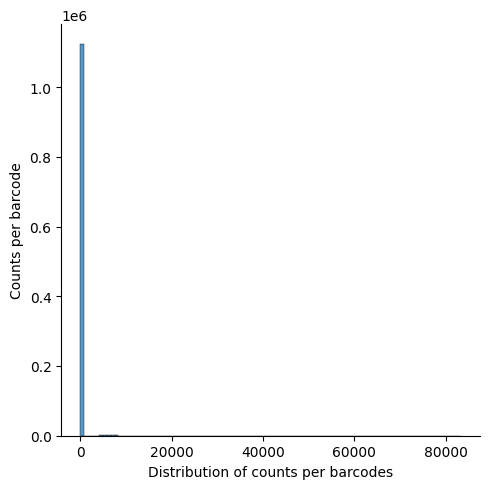

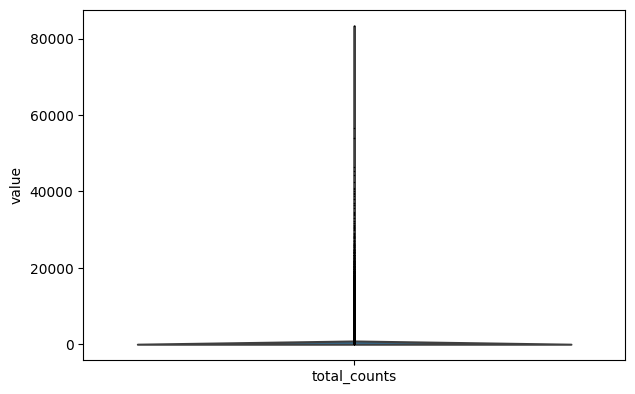

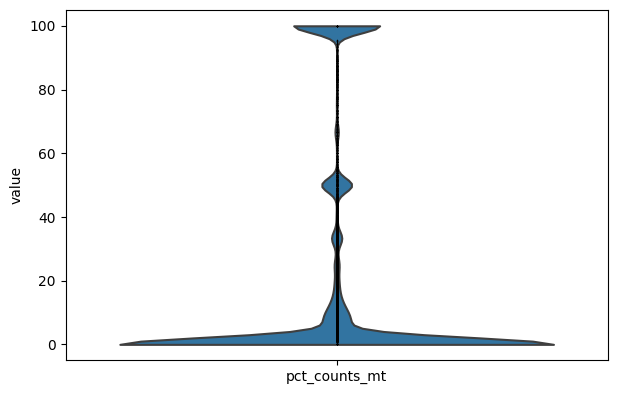

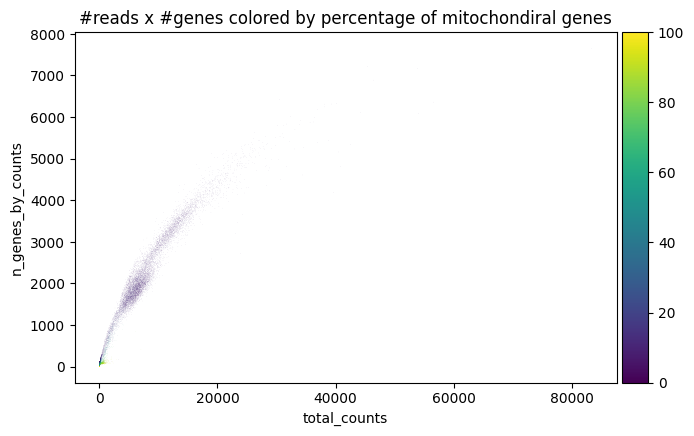

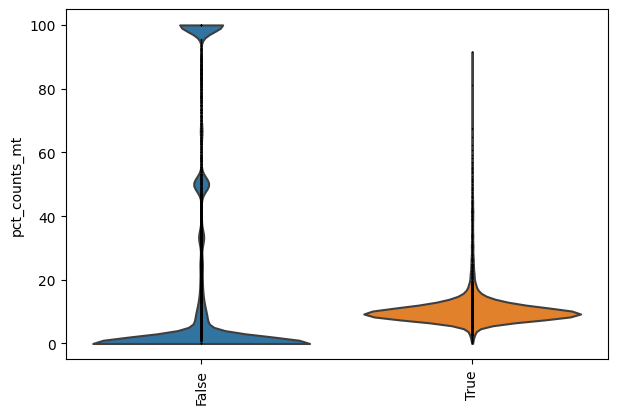

In [20]:
qc_plots(adata, "raw_data", "emptydrops_IsCell")

Emptydrop positive droplets

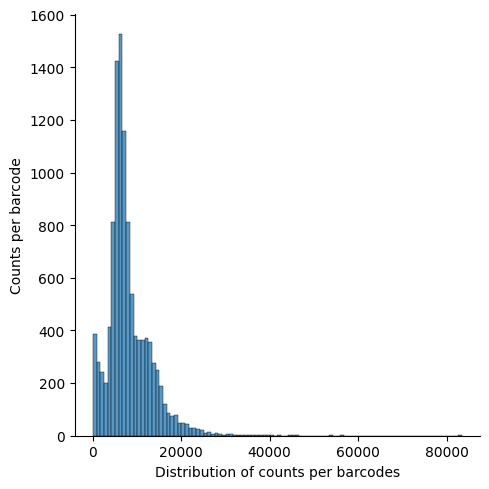

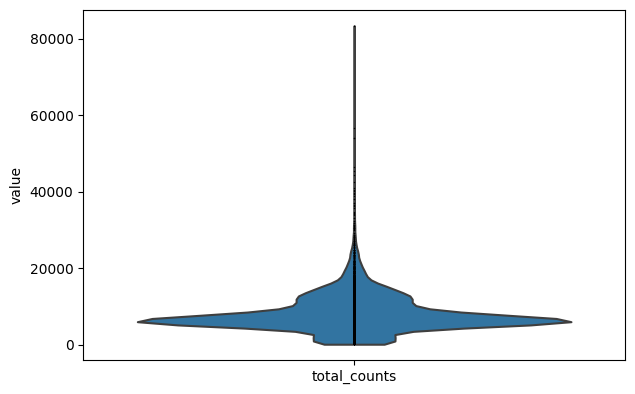

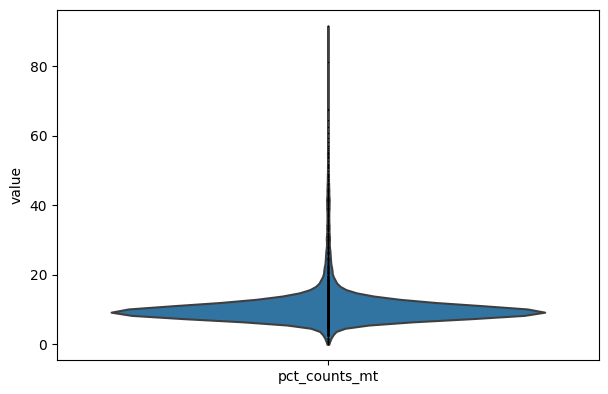

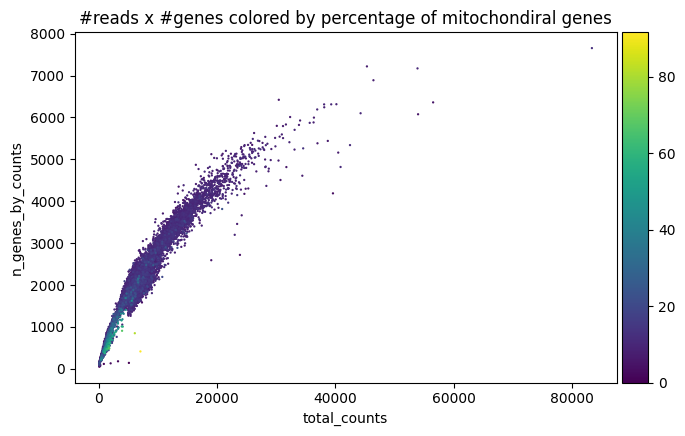

In [21]:
emptydrop_droplets_adata = adata[adata.obs.emptydrops_IsCell, :]
qc_plots(emptydrop_droplets_adata , "emptydrop_droplets", None)

CellBender positive droplets

In [23]:
# update the mt genes in adata
adata_cellbender.var['mt'] = adata_cellbender.var_names.str.startswith('MT-')


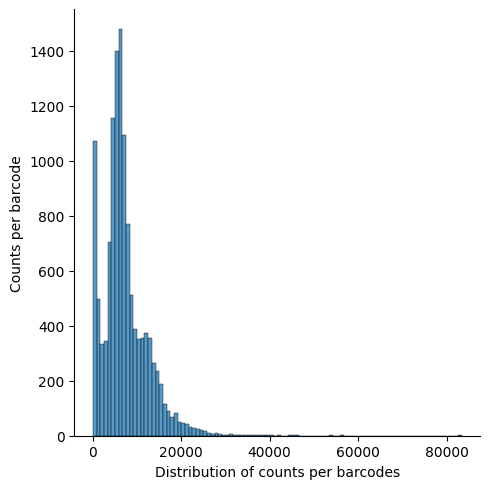

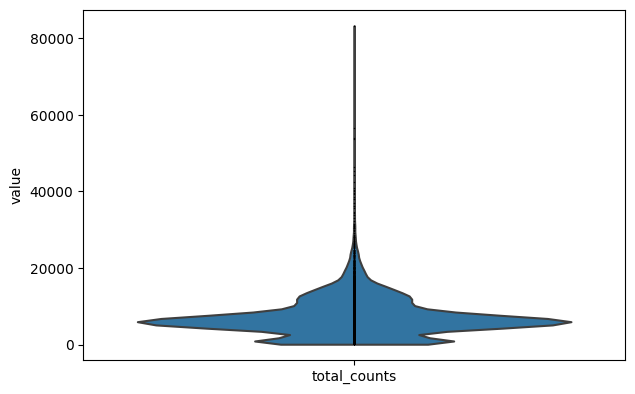

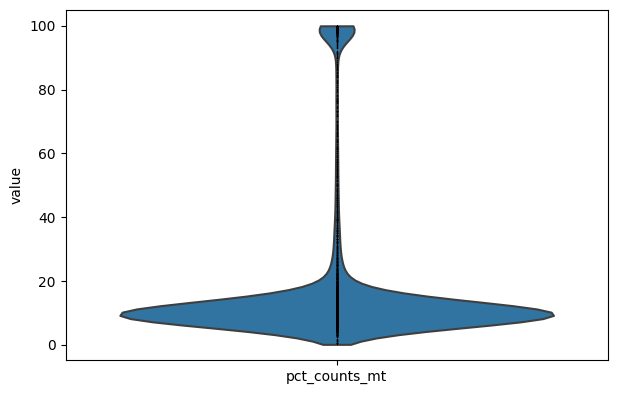

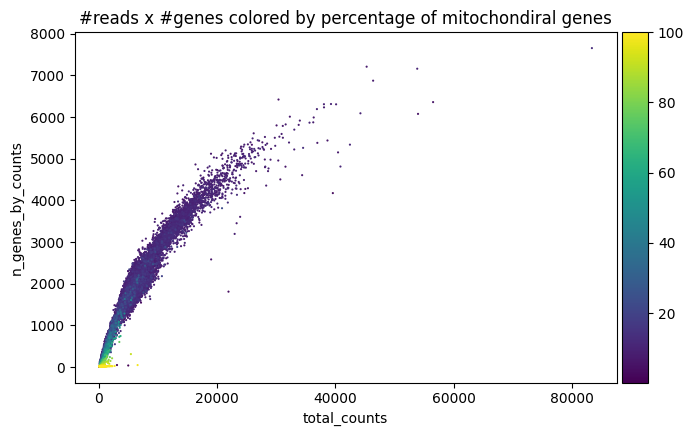

In [24]:
sc.pp.calculate_qc_metrics(
    adata_cellbender,
    qc_vars=["mt"],
    percent_top=[20],
    log1p=True,
    inplace=True
)
qc_plots(adata_cellbender , "cellbender_droplets", None)

#### Automatical QC metric based filtering

In [ ]:
# example of a hard thresholding
#barcodes_sup500, _ = sc.pp.filter_cells(adata, min_counts=500, inplace=False)
#adata_BCsup500 = adata[barcodes_sup500, :]

Raw data

In [69]:
"""
# Options for filtering
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_mt", 10)
).astype("category")
adata.obs.outlier.value_counts()
"""

False    621373
True     515539
Name: outlier, dtype: int64

In [110]:
# Outlier detection
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts",5)
    | is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 8)
).astype("category")
adata.obs.outlier.value_counts()

False    621373
True     515539
Name: outlier, dtype: int64

[Text(0.5, 1.0, '#reads x #genes for outliers and normal barcodes'),
 Text(0.5, 0, 'Number of reads per barcode'),
 Text(0, 0.5, 'Number of expressed genes per barcode')]

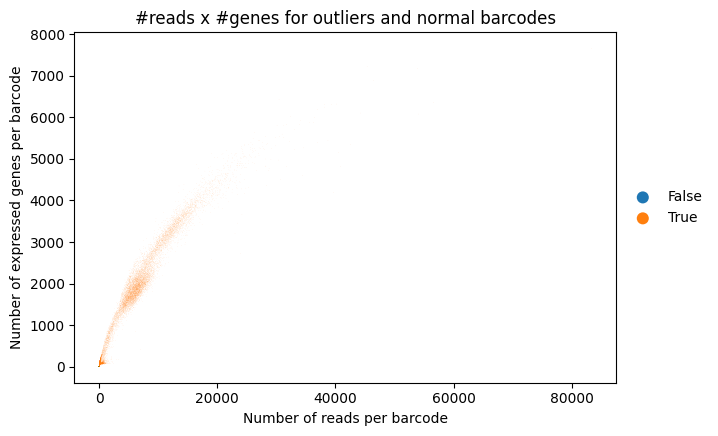

In [111]:
# Check repartition of the outliers
#why the "False" category is not displayed? they have a very low #reads and #genes
ax = sc.pl.scatter(
    adata, "total_counts", "n_genes_by_counts", color="outlier", show=False
)
ax.set(
    title="#reads x #genes for outliers and normal barcodes",
    xlabel="Number of reads per barcode",
    ylabel="Number of expressed genes per barcode",
)

In [112]:
# Filter the outliers
print(f"Total number of cells: {adata.n_obs}")
adata = adata[~adata.obs.outlier.astype("bool")] 
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 1136912
Number of cells after filtering of low quality cells: 621373


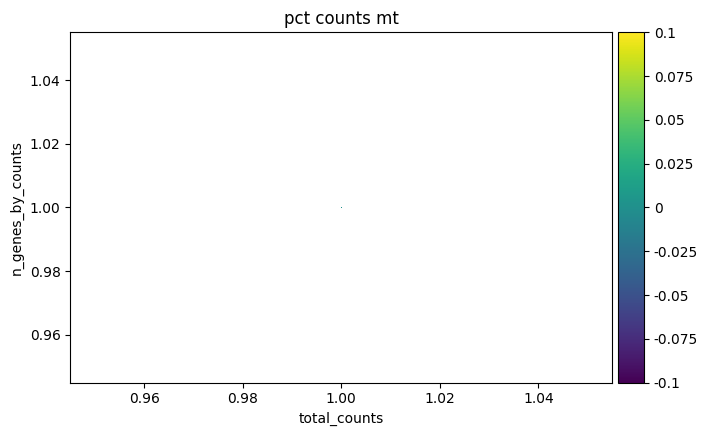

In [113]:
# check covariates after filtering
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

EmptyDrop positive droplets

In [149]:
emptydrop_droplets_adata.obs["outlier"] = (
    is_outlier(emptydrop_droplets_adata, "log1p_total_counts", 5)
    | is_outlier(emptydrop_droplets_adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(emptydrop_droplets_adata, "pct_counts_mt", 10)
).astype("category")
emptydrop_droplets_adata.obs.outlier.value_counts()

False    10233
True       798
Name: outlier, dtype: int64

In [146]:
"""
emptydrop_droplets_adata.obs["outlier"] = (
    is_outlier(emptydrop_droplets_adata, "log1p_total_counts", 5)
    | is_outlier(emptydrop_droplets_adata, "log1p_n_genes_by_counts",5)
    | is_outlier(emptydrop_droplets_adata, "pct_counts_mt", 3) | (emptydrop_droplets_adata.obs["pct_counts_mt"] > 8)
).astype("category")
emptydrop_droplets_adata.obs.outlier.value_counts()
"""

True     8930
False    2101
Name: outlier, dtype: int64

[Text(0.5, 1.0, '#reads x #genes for outliers and normal barcodes'),
 Text(0.5, 0, 'Number of reads per barcode'),
 Text(0, 0.5, 'Number of expressed genes per barcode')]

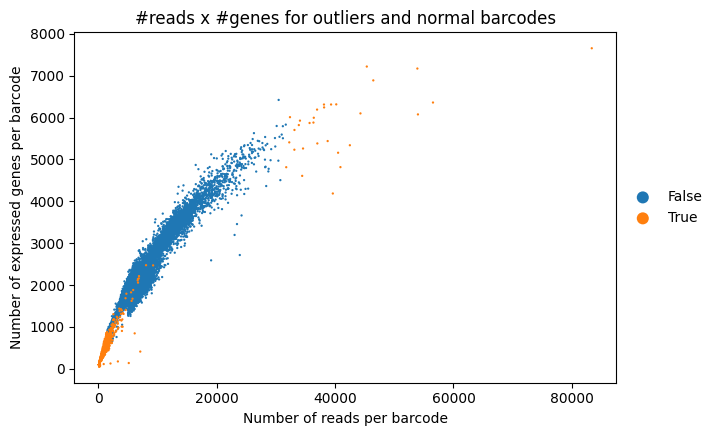

In [150]:
ax = sc.pl.scatter(
    emptydrop_droplets_adata, "total_counts", "n_genes_by_counts", color="outlier", show=False
)
ax.set(
    title="#reads x #genes for outliers and normal barcodes",
    xlabel="Number of reads per barcode",
    ylabel="Number of expressed genes per barcode",
)

In [151]:
print(f"Total number of cells: {emptydrop_droplets_adata.n_obs}")
emptydrop_droplets_adata = emptydrop_droplets_adata[~emptydrop_droplets_adata.obs.outlier.astype("bool")] 
print(f"Number of cells after filtering of low quality cells: {emptydrop_droplets_adata.n_obs}")

Total number of cells: 11031
Number of cells after filtering of low quality cells: 10233


[Text(0.5, 1.0, '#reads x #genes for outliers and normal barcodes'),
 Text(0.5, 0, 'Number of reads per barcode'),
 Text(0, 0.5, 'Number of expressed genes per barcode')]

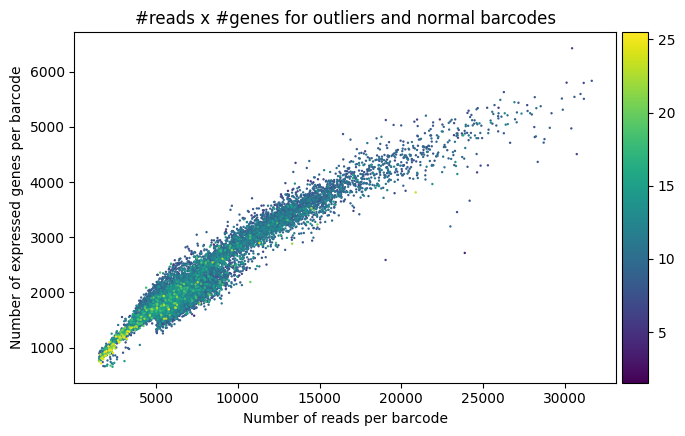

In [152]:
# check covariates after filtering
ax = sc.pl.scatter(
    emptydrop_droplets_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", show=False
)
ax.set(
    title="#reads x #genes for outliers and normal barcodes",
    xlabel="Number of reads per barcode",
    ylabel="Number of expressed genes per barcode",
)

CellBender positive droplets

In [158]:
adata_cellbender.obs["outlier"] = (
    is_outlier(adata_cellbender, "log1p_total_counts", 5)
    | is_outlier(adata_cellbender, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata_cellbender, "pct_counts_mt", 10)
).astype("category")
adata_cellbender.obs.outlier.value_counts()

False    11018
True      1543
Name: outlier, dtype: int64

[Text(0.5, 1.0, '#reads x #genes for outliers and normal barcodes'),
 Text(0.5, 0, 'Number of reads per barcode'),
 Text(0, 0.5, 'Number of expressed genes per barcode')]

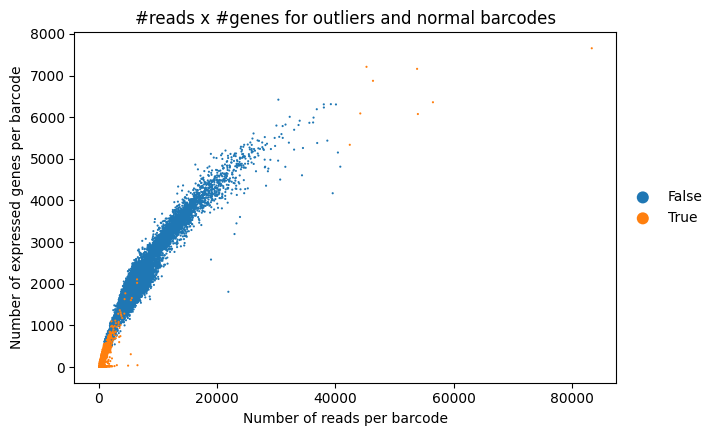

In [159]:
ax = sc.pl.scatter(
    adata_cellbender, "total_counts", "n_genes_by_counts", color="outlier", show=False
)
ax.set(
    title="#reads x #genes for outliers and normal barcodes",
    xlabel="Number of reads per barcode",
    ylabel="Number of expressed genes per barcode",
)

In [160]:
print(f"Total number of cells: {adata_cellbender.n_obs}")
adata_cellbender = adata_cellbender[~adata_cellbender.obs.outlier.astype("bool")] 
print(f"Number of cells after filtering of low quality cells: {adata_cellbender.n_obs}")

Total number of cells: 12561
Number of cells after filtering of low quality cells: 11018


[Text(0.5, 1.0, '#reads x #genes for outliers and normal barcodes'),
 Text(0.5, 0, 'Number of reads per barcode'),
 Text(0, 0.5, 'Number of expressed genes per barcode')]

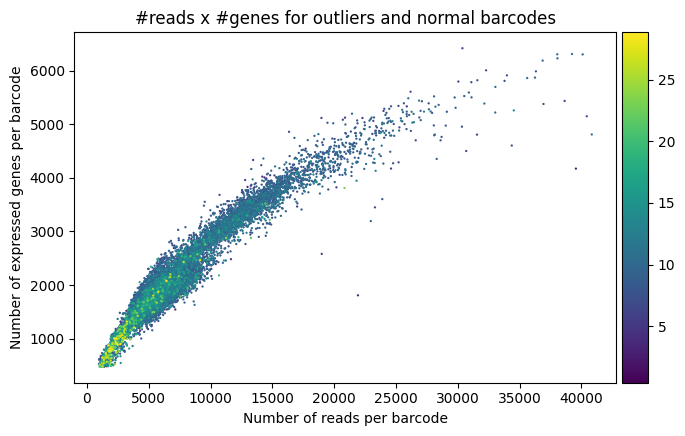

In [161]:
# check covariates after filtering
ax = sc.pl.scatter(
    adata_cellbender, "total_counts", "n_genes_by_counts", color="pct_counts_mt", show=False
)
ax.set(
    title="#reads x #genes for outliers and normal barcodes",
    xlabel="Number of reads per barcode",
    ylabel="Number of expressed genes per barcode",
)

Comparaison filtering results between emptydrop and cellbender positive droplets

In [169]:
adata_cellbender.obs.index
emptydrop_droplets_adata.obs.index
overlap_count = len(set(adata_cellbender.obs.index) & set(emptydrop_droplets_adata.obs.index))
print("Number of filtering barcode in cellbender positive droplets:", len(adata_cellbender.obs.index))
print("Number of filtering barcode in emptydrop positive droplets:", len(emptydrop_droplets_adata.obs.index))
print("Number of overlaps:", overlap_count)

Number of filtering barcode in cellbender positive droplets: 11018
Number of filtering barcode in emptydrop positive droplets: 10233
Number of overlaps: 10219


Write the filtered data of cellbender positive droplets to h5ad file

In [172]:
PATH_TO_OUTPUT = "../scAtlas/tmp/10k_pbmc_v3_out_filtered_cellbenderDefault_lowQcell.h5ad"
adata_cellbender.write_h5ad(PATH_TO_OUTPUT)

In [175]:
adata_cellbender

View of AnnData object with n_obs × n_vars = 11018 × 58347
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'barcode_indices_for_latents', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_el